In [1]:
"""
This notebook implements the plots in the Chapter 5.1 of the paper.  
https://arxiv.org/pdf/1007.1727v3.pdf

Author: Haoran Zhao
"""

'\nThis notebook implements the plots in the Chapter 5.1 of the paper.  \nhttps://arxiv.org/pdf/1007.1727v3.pdf\n\nAuthor: Haoran Zhao\n'

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import hist
import mplhep
from typing import Union

mplhep.style.use(mplhep.style.ATLAS)

np.random.seed(42)

# Figure 3(a)

In [7]:
# N_trails = 100000000
N_trails = 10000
mu = 0
s = 10
b = 10
tau = 1

n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

In [8]:
n_bins = 50
hist_2d = hist.Hist(
    hist.axis.Regular(n_bins, 0, n_bins, name="n_s"),
    hist.axis.Regular(n_bins, 0, n_bins, name="m_s"),
)

hist_2d.fill(n_s, m_s)

Hist(
  Regular(50, 0, 50, name='n_s'),
  Regular(50, 0, 50, name='m_s'),
  storage=Double()) # Sum: 10000.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x168bec4c0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

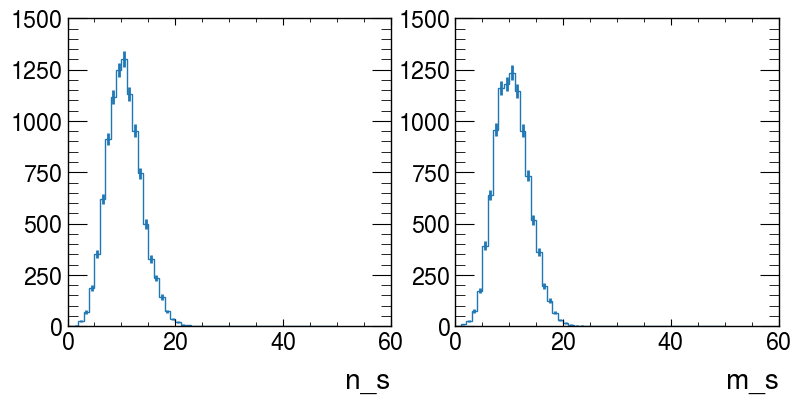

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
mplhep.histplot(hist_2d.project("n_s"), label="n_s", ax=axs[0])
mplhep.histplot(hist_2d.project("m_s"), label="m_s", ax=axs[1])

In [32]:
s = 10  # number of signal events
# tau = 1 # scale factor, general unknown.


def Likelihood(
    n: Union[int, np.array],
    m: Union[int, np.array],
    b: int,
    mu: float,
    tau: float = 1,
) -> Union[float, np.array]:
    poisson_sig = stats.poisson.pmf(mu=mu * s + b, k=n)
    poisson_bkg = stats.poisson.pmf(mu=tau * b, k=m)
    return poisson_sig * poisson_bkg


def MLE_mu_hat(
    n: Union[int, np.array],
    m: Union[int, np.array],
    tau: float = 1,
) -> Union[float, np.array]:
    return (n - m / tau) / (s)


def MLE_b_hat(
    m: Union[int, np.array],
    tau: float = 1,
) -> Union[float, np.array]:
    return m / tau


def MLE_b_hat_hat(
    n: Union[int, np.array],
    m: Union[int, np.array],
    mu: float,
    s: int,
    tau: float = 1,
) -> Union[float, np.array]:
    a = tau * (tau + 1)
    b = tau * (mu * s + tau * mu * s - m - n)
    c = -m * tau * mu * s

    return (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)


def Lambda_mu(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
) -> Union[float, np.array]:
    profiled_likelihood = Likelihood(n=n, m=m, mu=mu, b=MLE_b_hat_hat(n, m, mu, s))
    unconditional_likelihood = Likelihood(n=n, m=m, mu=MLE_mu_hat(n, m), b=MLE_b_hat(m))
    return profiled_likelihood / unconditional_likelihood


def Get_q0(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
):
    neg_index = np.where(MLE_mu_hat(n=n_s, m=m_s, tau=tau) < 0)[0]

    lambda_mu = Lambda_mu(n=n, m=m, mu=mu, s=s)
    lambda_mu[neg_index] = 1
    q0 = -2 * np.log(lambda_mu)
    # q0[neg_index] = 0
    # if MLE_mu_hat(n, m) >= 0:
    #     q0 = -2 * np.log(Lambda_mu(n=n, m=m, mu=mu))
    # else:
    #     q0 = 0
    return q0

100%|██████████| 4/4 [01:57<00:00, 29.32s/it]


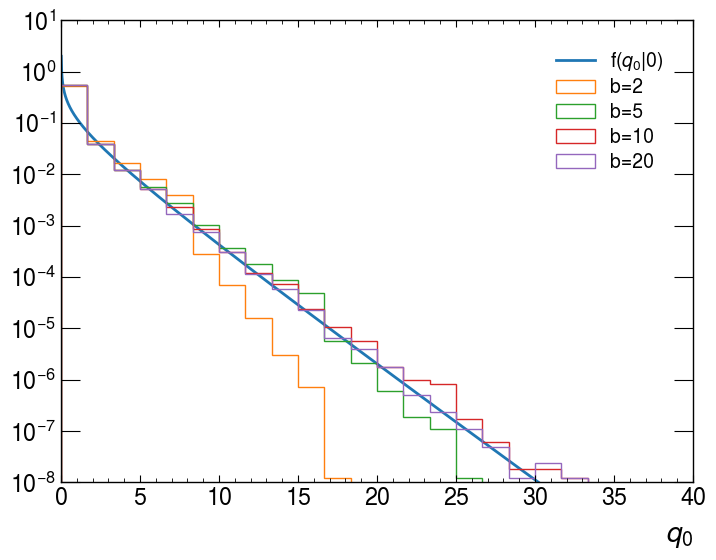

In [39]:
def f_q0(q0):
    """Asymptotic distribution of q0"""
    return 1 / 2 * 1 / np.sqrt(2 * np.pi) * 1 / np.sqrt(q0) * np.exp(-q0 / 2)


x_s = np.linspace(0.01, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")


b_s = [2, 5, 10, 20]
mu = 0
N_trails = 100000000
for b in tqdm(b_s):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
    q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
    ax.hist(q0_s, bins=24, range=(0, 40), density=True, histtype="step", label=f"b={b}")

ax.legend()
plt.show()

In [24]:
np.where(MLE_mu_hat(n=n_s, m=m_s, tau=tau) < 0)[0]

array([11, 16, 20, 21, 24, 25, 26, 27, 33, 36, 39, 40, 42, 43, 44, 46, 47,
       50, 51, 54, 55, 66, 67, 69, 74, 76, 77, 80, 82, 83, 86, 88, 89, 96,
       97, 99])

In [26]:
Lambda_mu(n=n_s, m=m_s, mu=mu, s=10)

array([0.78833184, 0.57819621, 0.76636464, 0.73931389, 1.        ,
       0.78833184, 0.86468611, 0.91995543, 0.78833184, 0.96719218,
       0.88220787, 0.91298601, 0.3727787 , 0.25686817, 1.        ,
       0.9487064 , 0.73931389, 0.66698178, 0.37038042, 0.69373389,
       0.63879183, 0.16109572, 0.07018838, 1.        , 0.71541395,
       0.96719218, 0.91995543, 0.21673252, 0.56019594, 0.43664318,
       0.78833184, 0.46859585, 0.60329856, 0.54826662, 0.97848875,
       0.69373389, 0.98019344, 0.92589067, 0.97401561, 0.77829072,
       0.97848875, 1.        , 0.96719218, 0.73424118, 0.43664318,
       0.31569684, 0.43664318, 0.76636464, 0.95550301, 0.12331755,
       0.96223213, 0.76531906, 0.66850576, 0.31381949, 0.88220787,
       0.3727787 , 0.97401561, 1.        , 1.        , 0.63879183,
       0.97401561, 0.91995543, 0.78833184, 1.        , 0.84619004,
       0.60329856, 0.57819621, 0.46859585, 0.84619004, 0.97646289,
       1.        , 0.97100006, 1.        , 0.22572721, 0.13636

In [37]:
def mu_hat(n: int, m: int) -> float:
    """Maximum likelihood estimator of mu, eqn 91.

    Args:
        n (int): the mean number of events from a signal model, known.
        m (int): the expected number from background processes.

    Returns:
        float: estimator value.
    """
    return (n - m / tau) / s


def b_hat(m: int) -> float:
    """Maximum likelihood estimator of b, eqn 92.

    Args:
        m (int): the expected number from background processes.

    Returns:
        float: estimator value.
    """
    return m / tau


def b_hat_hat(n: int, m: int, mu: float) -> float:
    """Maximum likelihood estimator of b, eqn 93.

    Args:
        n (int): the mean number of events from a signal model, known.
        m (int): the expected number from background processes.
        mu (float): signal strength parameter.

    Returns:
        float: estimator value.
    """
    a = tau * (tau + 1)
    b = tau * (mu * s + tau * mu * s - m - n)
    c = -m * tau * mu * s

    return -b / (2 * a) + np.sqrt(b**2 - 4 * a * c) / (2 * a)

``` mathematica

L[\[Mu]_, b_, s_, n_, \[Tau]_, 
  m_] := ((\[Mu] s + b)^n Exp[-(\[Mu] s + b)]/
     Factorial[n])*((\[Tau] b)^m Exp[-\[Tau] b]/Factorial[m])

dLd\[Mu] = D[L[\[Mu], b, s, n, \[Tau], m], \[Mu]];
sol\[Mu] = Solve[dLd\[Mu] == 0, \[Mu]]

dLdb = D[L[\[Mu], b, s, n, \[Tau], m], b];
solb = Solve[dLdb == 0, b]


```

In [13]:
def Lambda_mu(n, m, mu):
    return Likelihood(n=n, m=m, mu=mu, b=b_hat_hat(n, m, mu)) / Likelihood(
        n=n, m=m, mu=mu_hat(n, m), b=b_hat(m)
    )

In [14]:
def calculate_q0(n, m, mu):
    if mu_hat(n, m) >= 0:
        q0 = -2 * np.log(Lambda_mu(n=n, m=m, mu=mu))
    else:
        q0 = 0
    return q0

100%|██████████| 3/3 [03:44<00:00, 74.98s/it]


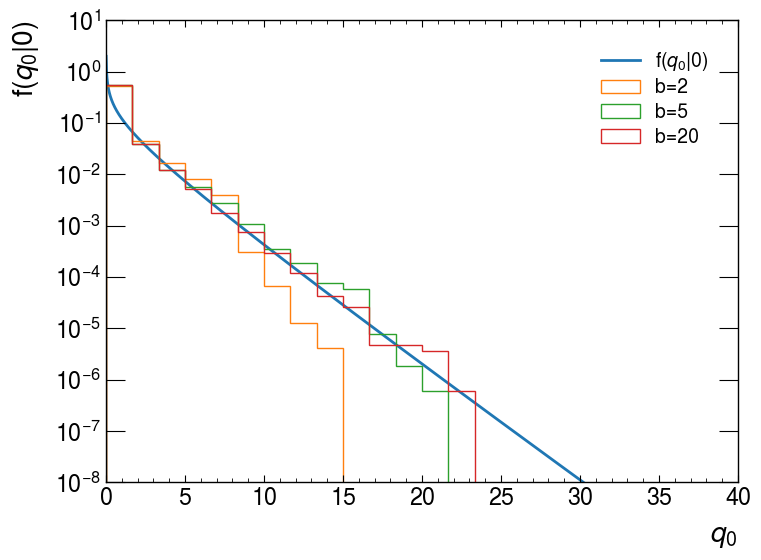

In [34]:
mu = 0
b_s = [2, 5, 20]

N_trails = 1000000


def f_q0(q0):
    """Asymptotic distribution of q0"""
    return 1 / 2 * 1 / np.sqrt(2 * np.pi) * 1 / np.sqrt(q0) * np.exp(-q0 / 2)


x_s = np.linspace(0.01, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

for b in tqdm(b_s):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

    nm_pairs = np.concatenate((n_s[:, None], m_s[:, None]), axis=1)

    q0_list = []
    for nm_pair in nm_pairs:
        q0_list.append(calculate_q0(n=nm_pair[0], m=nm_pair[1], mu=mu))

    # f_q0 = f_q0(q0 = x_s)
    ax.hist(
        q0_list, bins=24, range=(0, 40), density=True, histtype="step", label=f"b={b}"
    )


ax.set_ylabel(r"f($q_0$|0)")
ax.set_xlabel(r"$q_0$")
ax.legend()

# Figure 3(b)

In [22]:
s = 10
b = 10
tau = 1

In [30]:
def f_q0_mup(q0, mup=1):
    """Asymptotic distribution of q0"""
    q_0_A = -2 * np.log(calculate_q0(n=mup * s + b, m=tau * b, mu=mup))
    sigma = np.sqrt(mup**2 / q_0_A)
    return (
        1
        / 2
        * 1
        / np.sqrt(2 * np.pi)
        * 1
        / np.sqrt(q0)
        * np.exp(-1 / 2 * (q0 - mup / sigma) ** 2)
    )

/var/folders/l8/k4rv8vgs70nfv0kfc2d39n200000gn/T/ipykernel_43172/1390112738.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * 1/np.sqrt(2*np.pi) *  1/np.sqrt(q0) * np.exp(-q0/2)
/var/folders/l8/k4rv8vgs70nfv0kfc2d39n200000gn/T/ipykernel_43172/3332193525.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * 1/np.sqrt(2*np.pi) *  1/np.sqrt(q0) * np.exp(-1/2 *(q0 - mup / sigma)**2)


(1e-08, 10)

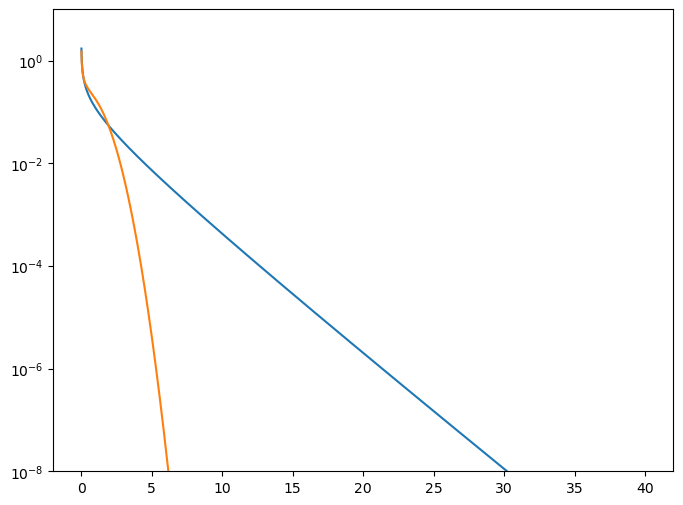

In [32]:
x_s = np.linspace(0, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
f_q0_mup_x = f_q0_mup(q0=x_s, mup=1)

ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.plot(x_s, f_q0_mup_x, label=r"f($q_0$|1)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)